Résultat partiel 1/65:
Paramètres: {'C': 0.001, 'max_iter': 1000, 'penalty': 'l1'}
Score moyen: 0.6325 (+/- 0.0016)
Temps de fit: 2708.62 secondes

Résultat partiel 2/65:
Paramètres: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l1'}
Score moyen: 0.6406 (+/- 0.0014)
Temps de fit: 7133.41 secondes

Résultat partiel 3/65:
Paramètres: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1'}
Score moyen: 0.6411 (+/- 0.0013)
Temps de fit: 7025.02 secondes

Résultat partiel 4/65:
Paramètres: {'C': 1, 'max_iter': 1000, 'penalty': 'l1'}
Score moyen: 0.6412 (+/- 0.0011)
Temps de fit: 8160.58 secondes

Résultat partiel 5/65:
Paramètres: {'C': 10, 'max_iter': 1000, 'penalty': 'l1'}
Score moyen: 0.6412 (+/- 0.0010)
Temps de fit: 9493.87 secondes

Résultat partiel 6/65:
Paramètres: {'C': 0.001, 'max_iter': 1000, 'penalty': 'l2'}
Score moyen: 0.6411 (+/- 0.0014)
Temps de fit: 2280.53 secondes

Résultat partiel 7/65:
Paramètres: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}
Score moyen: 0.6412 (+/- 0.0013)
Temps d

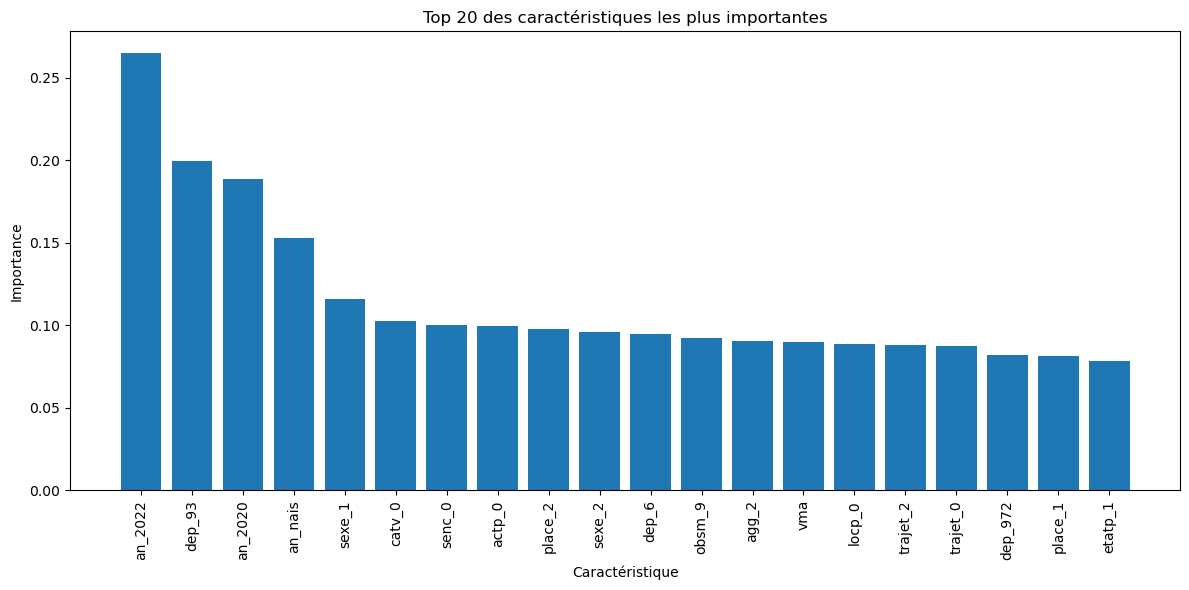


Top 5 des combinaisons de paramètres:
                                               params  mean_test_score  \
35  {'C': 0.1, 'l1_ratio': 0.30000000000000004, 'm...         0.641272   
34  {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 1000, ...         0.641238   
52  {'C': 1, 'l1_ratio': 0.9, 'max_iter': 1000, 'p...         0.641238   
3         {'C': 1, 'max_iter': 1000, 'penalty': 'l1'}         0.641235   
53  {'C': 1, 'l1_ratio': 1.0, 'max_iter': 1000, 'p...         0.641235   

    std_test_score     fit_time  
35        0.001241  7403.859024  
34        0.001180  7615.035331  
52        0.001136  8163.437277  
3         0.001134  8160.581479  
53        0.001134  8064.537532  

Top 20 des caractéristiques les plus importantes:
      feature  importance
249   an_2022    0.264819
361    dep_93    0.199400
247   an_2020    0.188754
6     an_nais    0.152998
66     sexe_1    0.115893
134    catv_0    0.102828
130    senc_0    0.100125
115    actp_0    0.099396
55    place_2    0.097703
6

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import time

# Chargement et prétraitement des données
final_merged_df = pd.read_csv('data/processed/data.csv', index_col=0)

X = final_merged_df.drop(columns=['grav'])
y = final_merged_df['grav']

dummy_columns = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'prof', 'place', 'catu', 'sexe', 
                 'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp', 'senc', 'catv', 'obs', 
                 'obsm', 'choc', 'manv', 'motor', 'plan', 'surf','an','infra','dep','situ','vosp']
columns_to_scale = [col for col in X.columns if col not in dummy_columns]

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

# Création d'un ensemble d'entraînement et d'un ensemble test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=12)

# Réduction de dimension
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Définition du classificateur
LR = LogisticRegression(random_state=123, tol=1e-3, solver='saga')

# Validation croisée
cv5 = KFold(n_splits=5, random_state=111, shuffle=True)

# Définition de l'espace de recherche des hyperparamètres
param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1'], 'max_iter': [1000]},
    {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2'], 'max_iter': [1000]},
    {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['elasticnet'], 'max_iter': [1000], 'l1_ratio': np.linspace(0, 1, 11)}
]


# Création d'un GridSearchCV personnalisé pour sauvegarder les résultats partiels
class GridSearchWithProgress(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        n_candidates = sum(len(ParameterGrid(grid)) for grid in self.param_grid)
        n_completed = 0
        
        results = []
        
        for params in ParameterGrid(self.param_grid):
            start_time = time.time()
            self.estimator.set_params(**params)
            cv_results = cross_validate(self.estimator, X, y, cv=self.cv, scoring=self.scoring, return_train_score=True)
            end_time = time.time()
            
            result = {
                'params': params,
                'mean_test_score': cv_results['test_score'].mean(),
                'std_test_score': cv_results['test_score'].std(),
                'fit_time': end_time - start_time
            }
            
            results.append(result)
            
            n_completed += 1
            
            # Enregistrer les résultats partiels
            joblib.dump(results, 'grid_search_resultsLR.joblib')
            
            # Affichage des résultats partiels
            print(f"Résultat partiel {n_completed}/{n_candidates}:")
            print(f"Paramètres: {params}")
            print(f"Score moyen: {cv_results['test_score'].mean():.4f} (+/- {cv_results['test_score'].std():.4f})")
            print(f"Temps de fit: {end_time - start_time:.2f} secondes")
            print()
            
        self.cv_results_ = results
        best_index = max(range(len(results)), key=lambda i: results[i]['mean_test_score'])
        self.best_params_ = results[best_index]['params']
        self.best_score_ = results[best_index]['mean_test_score']
        
        # Définition du meilleur estimateur
        self.best_estimator_ = self.estimator.set_params(**self.best_params_)
        self.best_estimator_.fit(X, y)
        
        return self

# Exécution du GridSearchCV avec contrôle de l'état d'avancement
grid_search = GridSearchWithProgress(LR, param_grid, cv=cv5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_pca, y_train)

# Chargement des résultats enregistrés
results = joblib.load('grid_search_resultsLR.joblib')

# Affichage des meilleurs paramètres et du meilleur score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score:", grid_search.best_score_)

# Utilisation du meilleur modèle
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_pca)
print("Accuracy du meilleur modèle:", accuracy_score(y_test, y_pred_best))

# Rapport de classification détaillé pour le meilleur modèle
print("\nRapport de classification du meilleur modèle:\n", classification_report(y_test, y_pred_best, zero_division=0))

# Matrice de confusion pour le meilleur modèle
print("\nMatrice de confusion du meilleur modèle:\n", confusion_matrix(y_test, y_pred_best))

# Calcul de l'importance des caractéristiques originales
coef = best_model.coef_[0]
original_feature_importance = np.abs(coef.dot(pca.components_))

# Création d'un DataFrame avec les noms des colonnes originales et leur importance
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': original_feature_importance
})

# Top 20 des caractéristiques par importance décroissante
top_20_features = feature_importance_df.sort_values('importance', ascending=False).head(20)

# Visualisation des coefficients (top 20 en valeur absolue)
plt.figure(figsize=(12, 6))
plt.bar(top_20_features['feature'], top_20_features['importance'])
plt.xticks(rotation=90)
plt.title("Top 20 des caractéristiques les plus importantes")
plt.xlabel("Caractéristique")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Affichage des résultats pour tous les essais
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('mean_test_score', ascending=False)
print("\nTop 5 des combinaisons de paramètres:")
print(results_df[['params', 'mean_test_score', 'std_test_score', 'fit_time']].head())

# Affichage du top 20 des caractéristiques les plus importantes
print("\nTop 20 des caractéristiques les plus importantes:")
print(top_20_features)

In [3]:
# Sauvegarde du meilleur modèle
joblib.dump(best_model, 'best_model_LR.joblib')

['best_model_LR.joblib']